In [2]:
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle

In [3]:
with open("CaseStudyFile/Data/xgb_model_w_data.pkl", "rb") as f:
    features_response, X_train_all,\
    y_train_all, X_test_all, y_test_all, xgb_model_4 = pickle.load(f)

In [4]:
test_set_pred_proba = xgb_model_4.predict_proba(X_test_all)[:,1]

In [5]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test_all, test_set_pred_proba)
test_auc

0.771827890629116

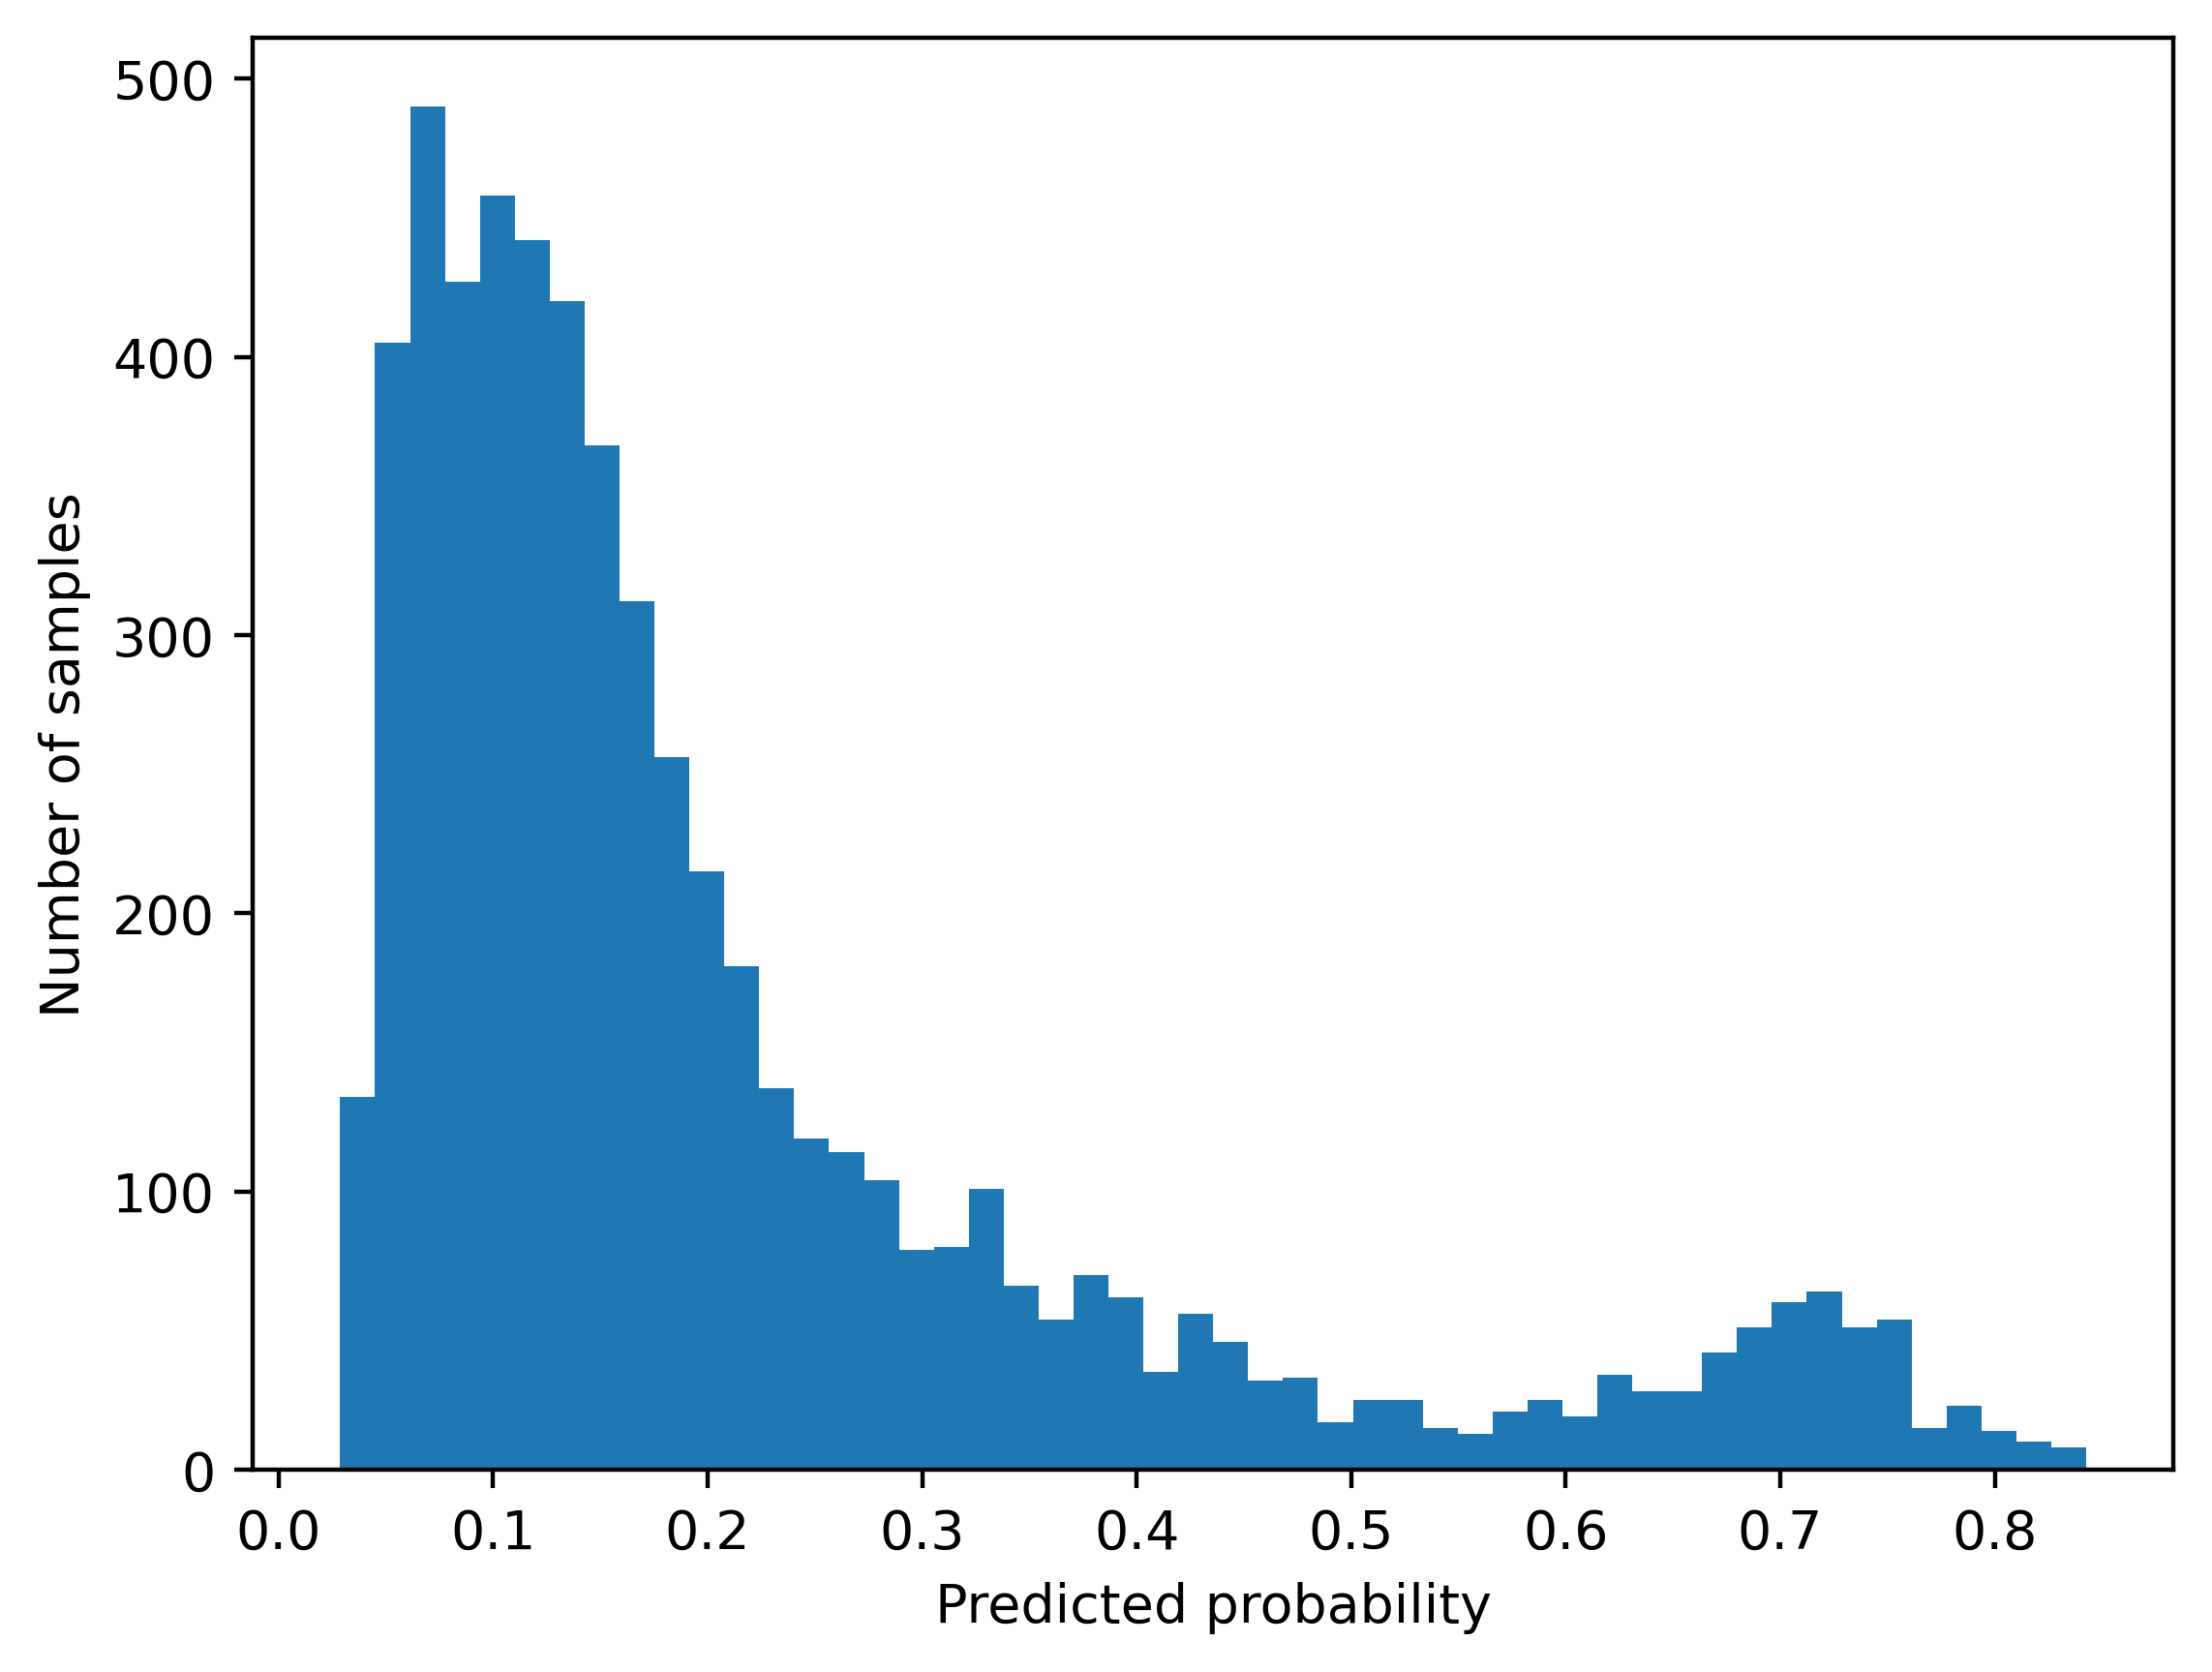

In [6]:
mpl.rcParams['figure.dpi'] = 400
plt.hist(test_set_pred_proba, bins = 50)
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')
plt.show()

In [7]:
deciles, decile_bin_edges = pd.qcut(x = test_set_pred_proba, q = 10, retbins = True)
decile_bin_edges

array([0.02866817, 0.06296656, 0.08341031, 0.10531277, 0.1270338 ,
       0.15042238, 0.18233756, 0.23004555, 0.32266536, 0.51780742,
       0.84259713])

In [8]:
test_set_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                             'Prediction decile':deciles, 'Outcome':y_test_all})
test_set_df.head()

,Predicted probability,Prediction decile,Outcome
0,0.688628,"(0.518, 0.843]",0
1,0.634731,"(0.518, 0.843]",0
2,0.053137,"(0.0277, 0.063]",0
3,0.842597,"(0.518, 0.843]",1
4,0.325197,"(0.323, 0.518]",0


In [9]:
test_set_gr = test_set_df.groupby('Prediction decile')
gr_df = test_set_gr.agg({'Outcome':['count', 'mean']})
gr_df

C:\Users\HI\AppData\Local\Temp\ipykernel_7948\3636182326.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_set_gr = test_set_df.groupby('Prediction decile')


Outcome          
                    count      mean
Prediction decile                  
(0.0277, 0.063]       594  0.050505
(0.063, 0.0834]       594  0.063973
(0.0834, 0.105]       594  0.102694
(0.105, 0.127]        593  0.094435
(0.127, 0.15]         594  0.158249
(0.15, 0.182]         594  0.149832
(0.182, 0.23]         593  0.202361
(0.23, 0.323]         594  0.281145
(0.323, 0.518]        594  0.398990
(0.518, 0.843]        594  0.661616

In [10]:
gr_df.columns

MultiIndex([('Outcome', 'count'),
            ('Outcome',  'mean')],
           )

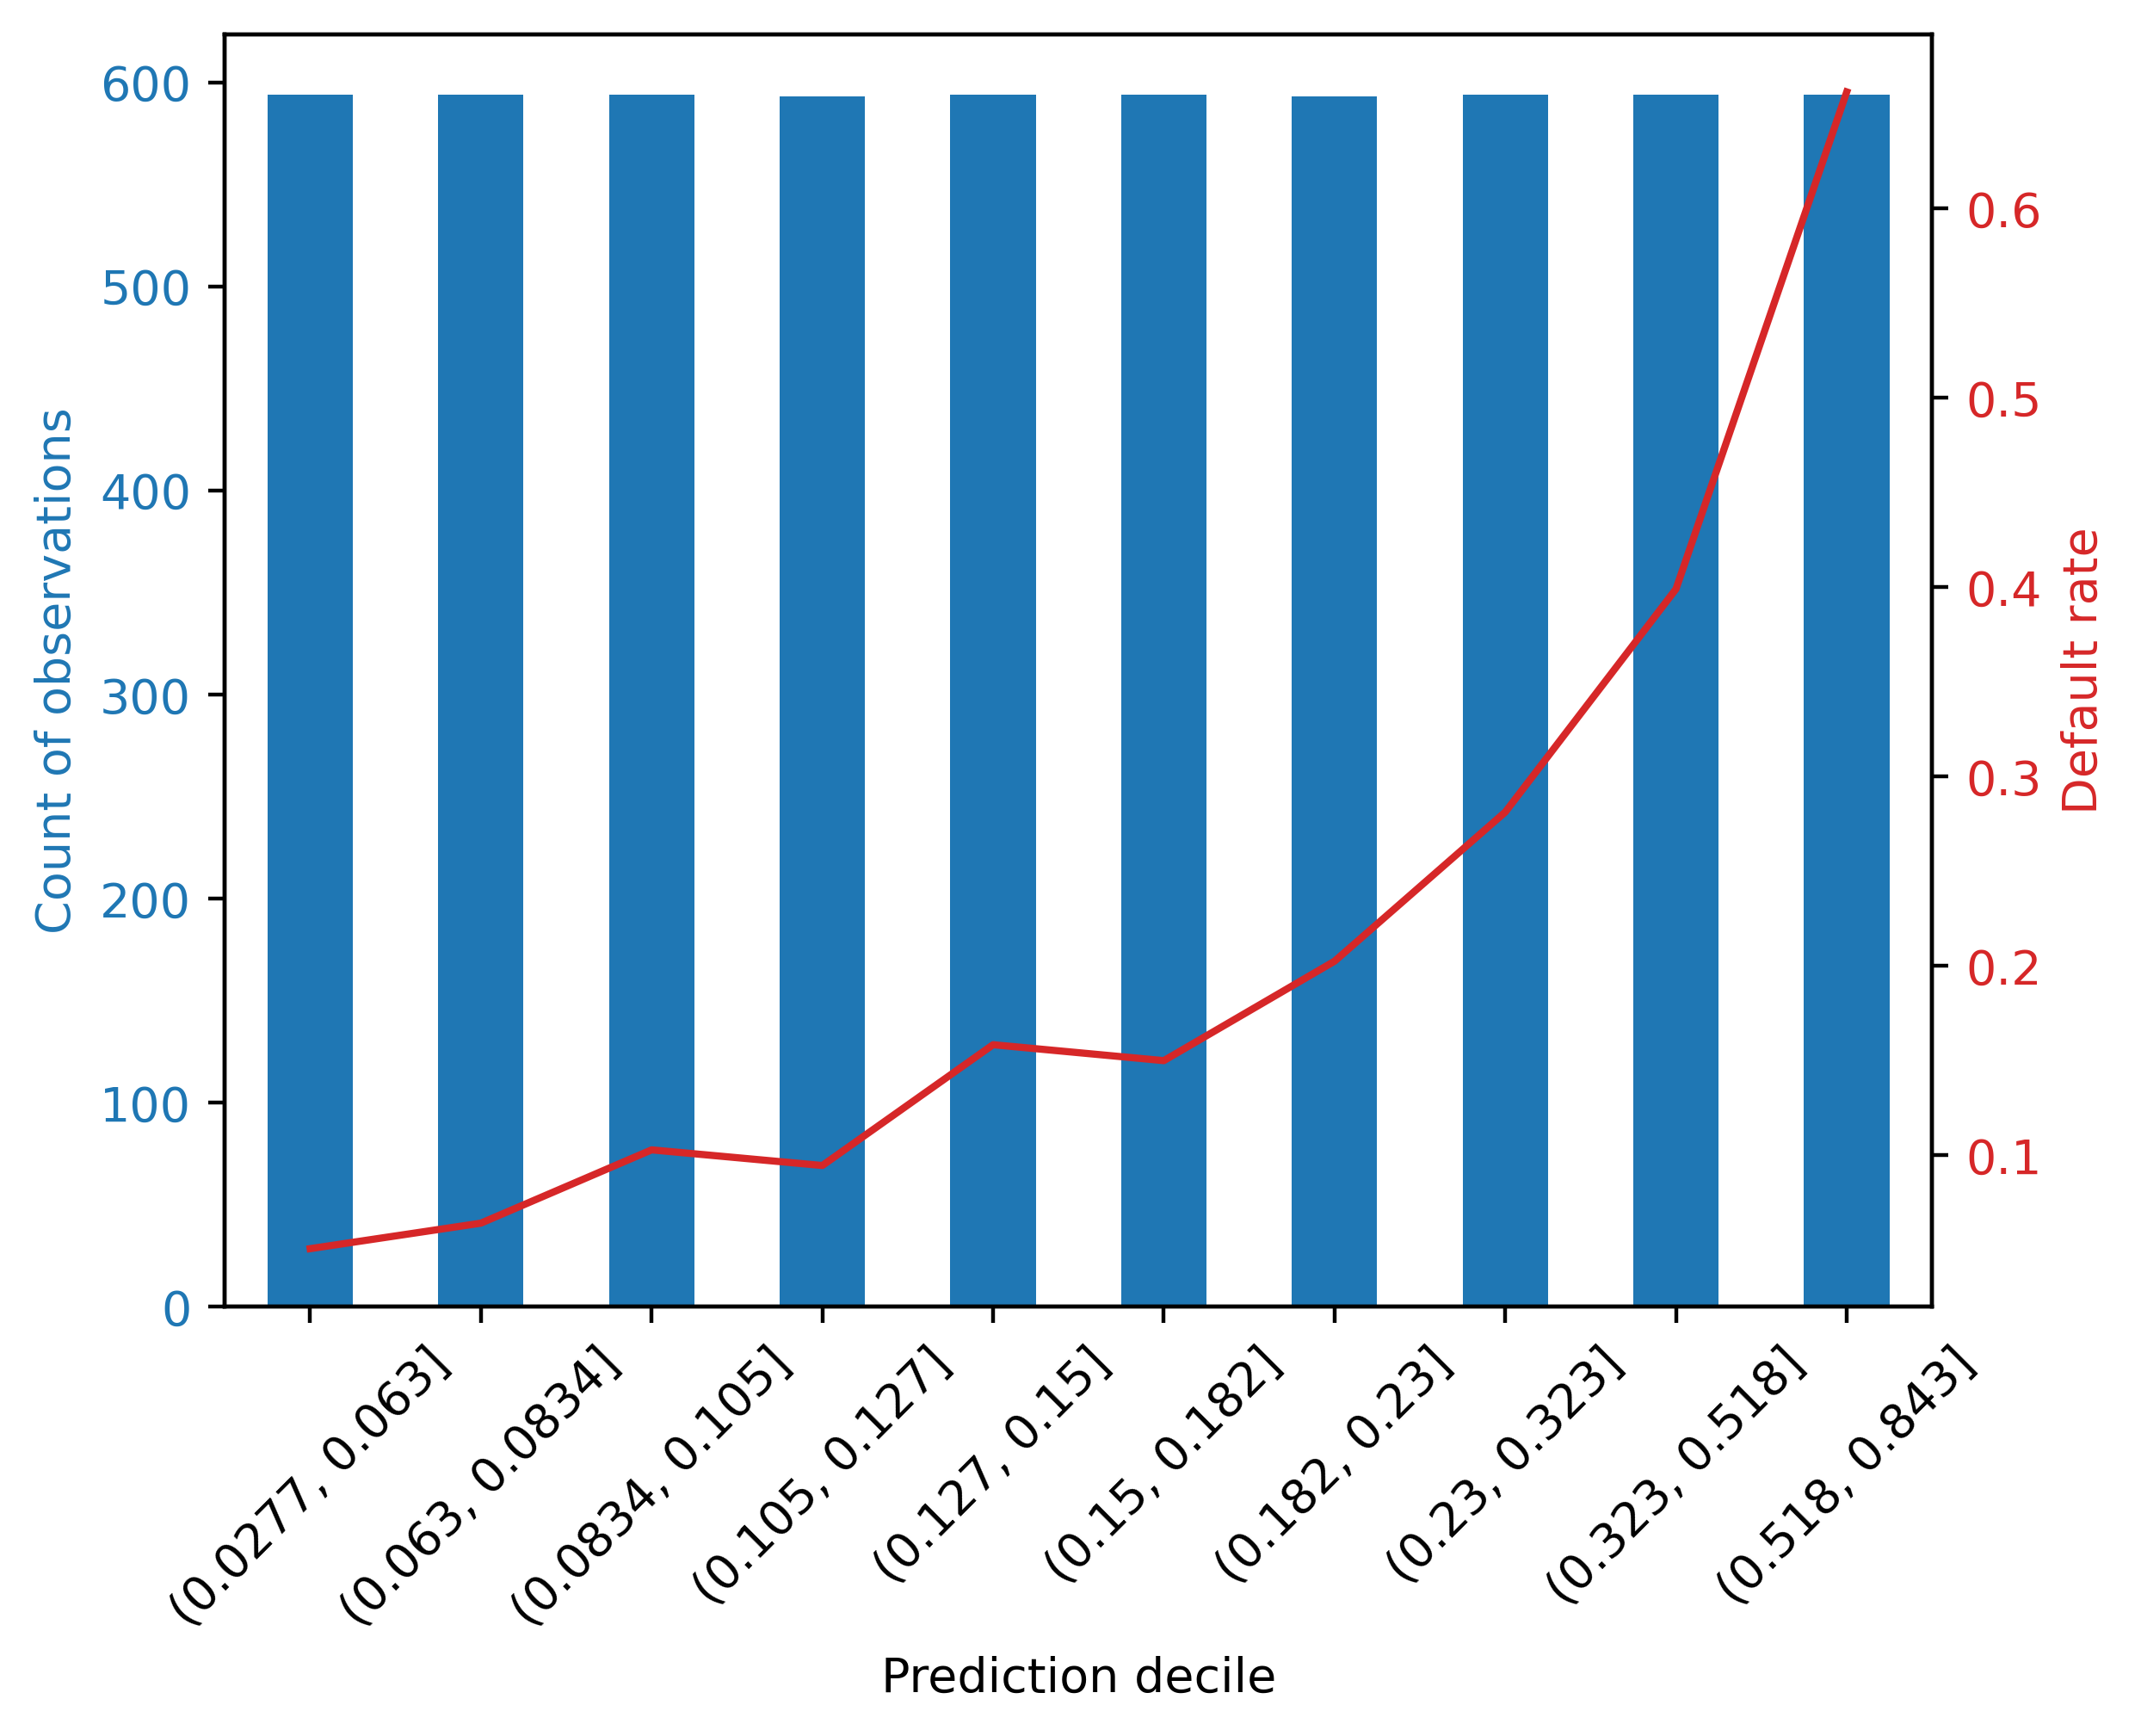

In [11]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_df[('Outcome', 'count')].plot.bar(ax = ax_1, color = color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)
plt.show()

In [12]:
equal_intervals, equal_interval_bin_edges =\
    pd.cut(x = test_set_pred_proba, bins = 5, retbins = True)
equal_interval_bin_edges

array([0.02785425, 0.19145397, 0.35423976, 0.51702555, 0.67981134,
       0.84259713])

In [13]:
equal_interval_bin_edges[1:] - equal_interval_bin_edges[:-1]

array([0.16359972, 0.16278579, 0.16278579, 0.16278579, 0.16278579])

In [14]:
test_set_bins_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,\
 'Prediction bin':equal_intervals,\
 'Outcome':y_test_all})
test_set_bins_df.head()

,Predicted probability,Prediction bin,Outcome
0,0.688628,"(0.68, 0.843]",0
1,0.634731,"(0.517, 0.68]",0
2,0.053137,"(0.0279, 0.191]",0
3,0.842597,"(0.68, 0.843]",1
4,0.325197,"(0.191, 0.354]",0


In [15]:
test_set_equal_gr = test_set_bins_df.groupby('Prediction bin')
gr_eq_df = test_set_equal_gr.agg({'Outcome':['count', 'mean']})
gr_eq_df

C:\Users\HI\AppData\Local\Temp\ipykernel_7948\2042368696.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_set_equal_gr = test_set_bins_df.groupby('Prediction bin')


Outcome          
                  count      mean
Prediction bin                   
(0.0279, 0.191]    3712  0.104795
(0.191, 0.354]     1196  0.258361
(0.354, 0.517]      430  0.446512
(0.517, 0.68]       250  0.560000
(0.68, 0.843]       350  0.728571

In [16]:
p = gr_eq_df[('Outcome', 'mean')].values
n = gr_eq_df[('Outcome', 'count')].values
std_err = np.sqrt(p*(1-p)/n)
std_err

array([0.00502722, 0.01265739, 0.02397377, 0.03139427, 0.02377004])

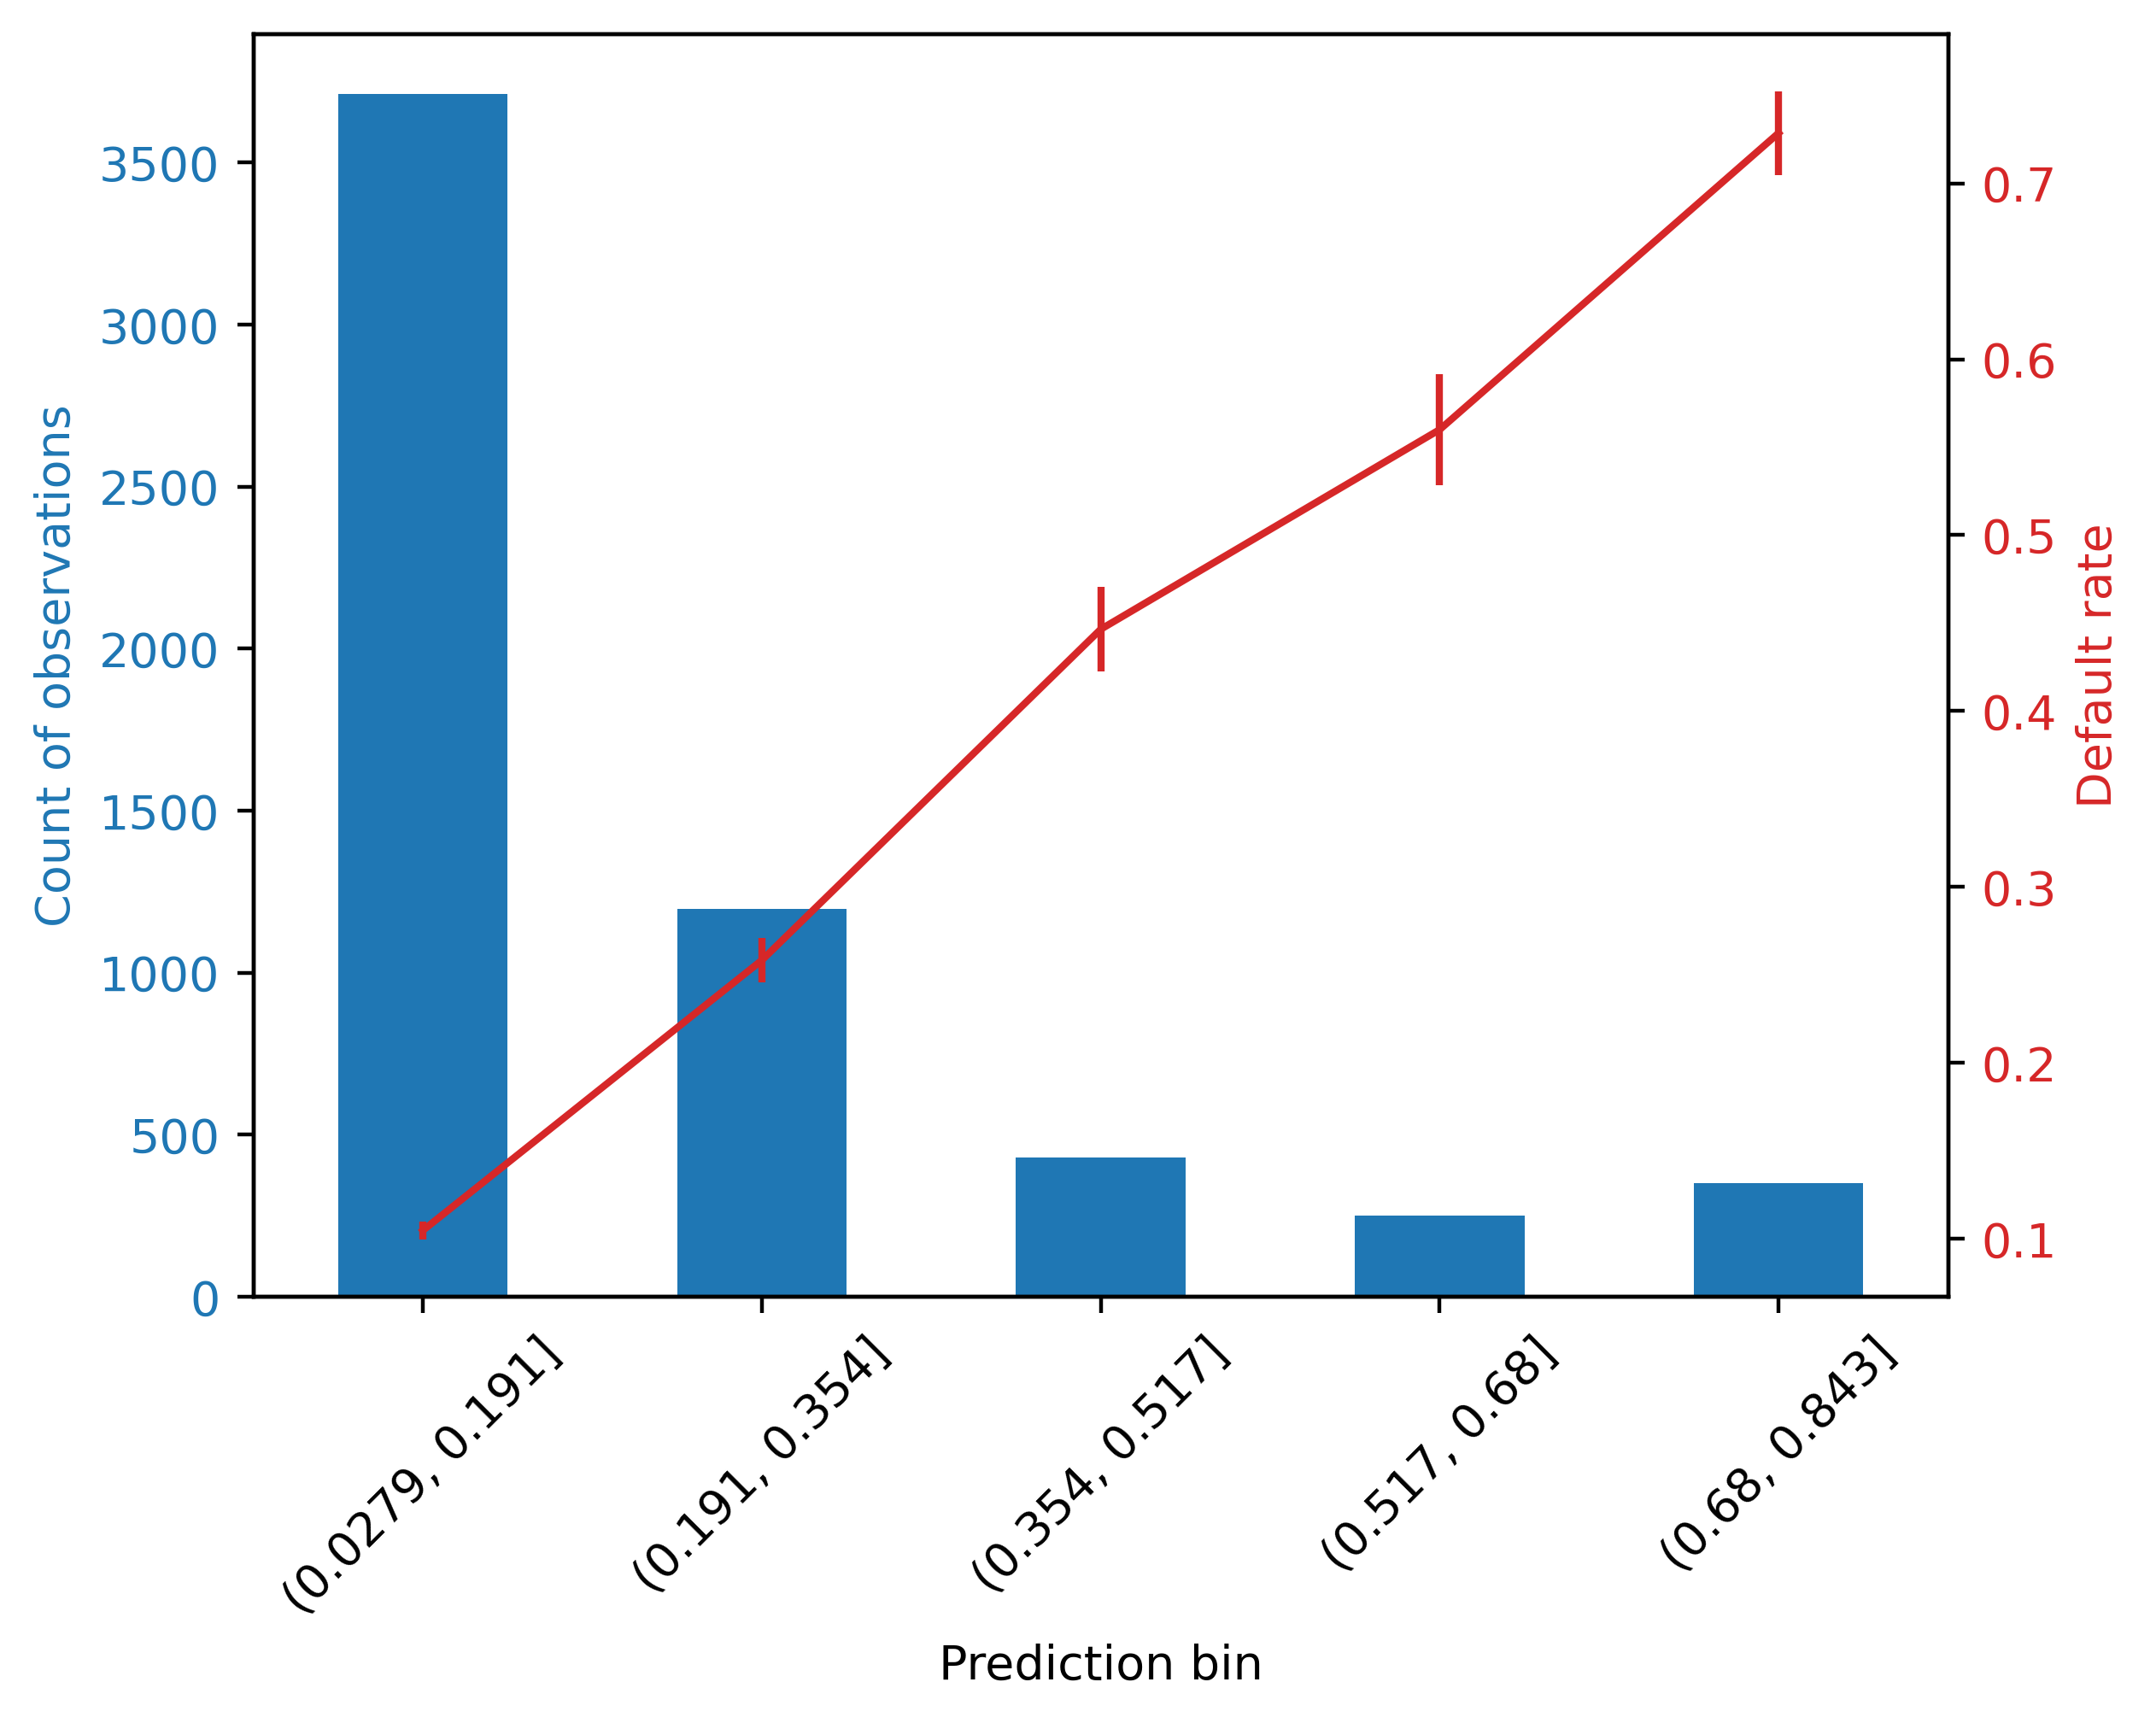

In [17]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_eq_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)
ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_eq_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2,
yerr=std_err)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)
plt.show()


In [18]:
cal_df = test_set_gr.agg({'Outcome':['count', 'mean'], 'Predicted probability':'mean'})
cal_df

Outcome           Predicted probability
                    count      mean                  mean
Prediction decile                                        
(0.0277, 0.063]       594  0.050505              0.051289
(0.063, 0.0834]       594  0.063973              0.072878
(0.0834, 0.105]       594  0.102694              0.094526
(0.105, 0.127]        593  0.094435              0.115772
(0.127, 0.15]         594  0.158249              0.138396
(0.15, 0.182]         594  0.149832              0.165363
(0.182, 0.23]         593  0.202361              0.203339
(0.23, 0.323]         594  0.281145              0.271644
(0.323, 0.518]        594  0.398990              0.398954
(0.518, 0.843]        594  0.661616              0.684623

In [19]:
F = cal_df[('Outcome', 'count')].values /y_test_all.shape[0]
F

array([0.10003368, 0.10003368, 0.10003368, 0.09986527, 0.10003368,
       0.10003368, 0.09986527, 0.10003368, 0.10003368, 0.10003368])

In [20]:
ECE = np.sum(F*np.abs(cal_df[('Outcome', 'mean')]
             - cal_df[('Predicted probability', 'mean')]))

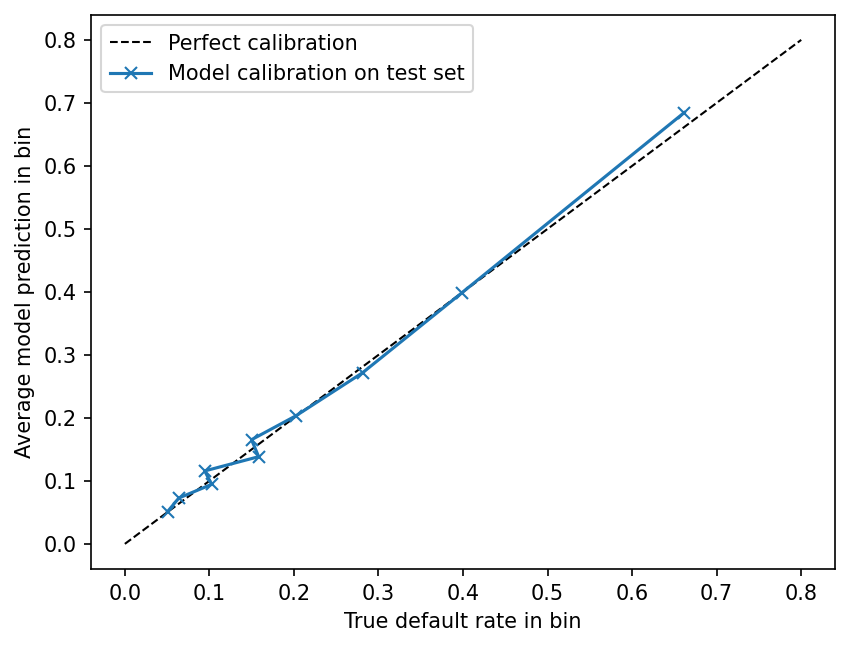

In [21]:
mpl.rcParams['figure.dpi'] = 150
ax = plt.axes()
ax.plot([0, 0.8], [0, 0.8], 'k--', linewidth = 1, 
        label = 'Perfect calibration')
ax.plot(cal_df[('Outcome', 'mean')], cal_df[('Predicted probability', 'mean')], marker = 'x', 
        label = 'Model calibration on test set')
ax.set_xlabel('True default rate in bin')
ax.set_ylabel('Average model prediction in bin')
ax.legend()
plt.show()

#### Characterizing Costs and Savings

In [29]:
thresholds = np.linspace(0, 1, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [25]:
features_response[5]

'BILL_AMT1'

In [30]:
cost_per_counseling = 7500
effectiveness = 0.70

In [33]:
no_pos_pred = np.empty_like(thresholds)
total_cost = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
total_savings = np.empty_like(thresholds)

In [35]:
counter = 0
for threshold in thresholds:
    pos_pred = test_set_pred_proba > threshold
    no_pos_pred[counter] = sum(pos_pred)
    total_cost[counter] = no_pos_pred[counter] * cost_per_counseling
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    total_savings[counter] = np.sum(true_pos.astype(int) * X_test_all[:,5] * effectiveness)
    counter += 1

In [36]:
net_savings = total_savings - total_cost
net_savings

array([-2123565.90000001, -2123565.90000001, -2123565.90000001,
       -2116065.90000001, -1738633.10000001,  -507528.40000001,
         910212.8       ,  2536686.7       ,  3567746.9       ,
        4303135.        ,  4680519.89999999,  5808075.5       ,
        6892936.1       ,  6740501.3       ,  7393467.8       ,
        8112119.2       ,  8914401.        ,  9636203.        ,
       10186759.3       , 10662580.1       , 10967049.1       ,
       11547756.3       , 11458138.3       , 11775691.1       ,
       11546096.1       , 11840145.9       , 12022326.5       ,
       12124647.4       , 11972632.9       , 12339605.9       ,
       12388084.2       , 12529220.5       , 12522954.1       ,
       12641650.8       , 12618851.6       , 12743911.2       ,
       12510984.5       , 12470692.6       , 12645129.1       ,
       12509697.        , 12473787.9       , 12621116.9       ,
       12654378.7       , 12759053.        , 12244324.2       ,
       12256457.        , 12211214.9    

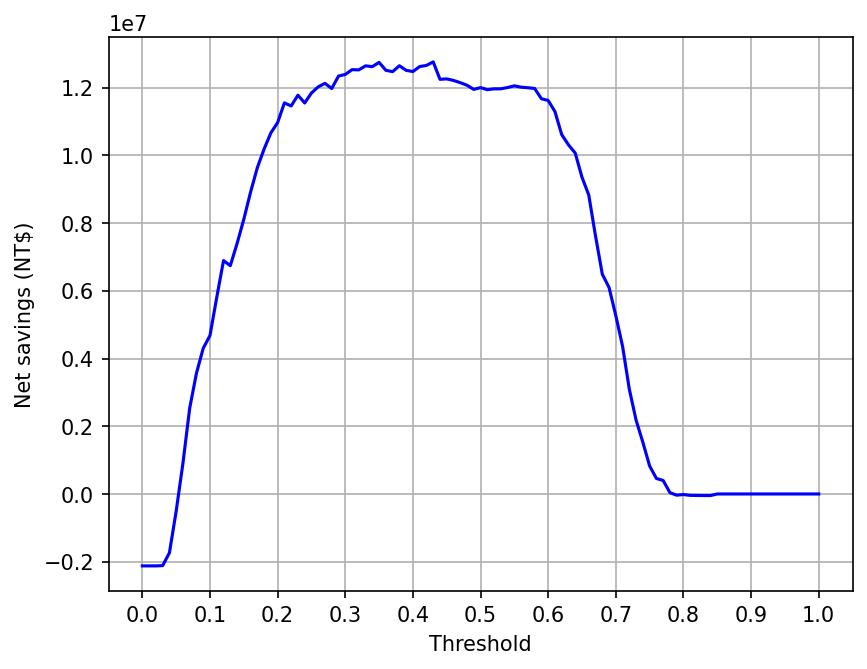

In [41]:
plt.plot(thresholds, net_savings, color='blue')
plt.xlabel('Threshold')
plt.ylabel("Net savings (NT$)")
plt.xticks(np.linspace(0,1,11))
plt.grid(True)
plt.show()